In [362]:
import eli5
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import OrdinalEncoder
from eli5.sklearn import PermutationImportance
from glob import glob
from IPython.display import display, Markdown
from ipywidgets import interact, fixed
from mlxtend.plotting import plot_decision_regions
from scipy.stats import percentileofscore
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.utils.multiclass import unique_labels
from tqdm import tnrange, tqdm_notebook
from xgboost import XGBClassifier

In [363]:
%matplotlib inline
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

In [364]:
# files = glob('LoanStats*.csv')

# def a_to_d_done(df):
#     a_to_d = df['grade'].isin(['A', 'B', 'C', 'D'])
#     done = df['loan_status'].isin(['Fully Paid', 'Charged Off'])
#     return a_to_d & done

# dfs = (pd.read_csv(file, skiprows=1, skipfooter=2, engine='python')
#        .where(a_to_d_done)
#        .dropna(subset=['grade', 'loan_status'])
#        for file in tqdm_notebook(files))

# df = pd.concat(dfs)

In [365]:
# historical, _ = train_test_split(df.copy(), train_size=0.10, 
#                              stratify=df['loan_status'])

In [366]:
# historical.to_csv('historical.csv', index=False)

In [403]:
df = pd.read_csv('data/historical.csv')
df.shape

(128334, 144)

In [404]:
current = pd.read_csv('data/primaryMarketNotes_browseNotes_1-RETAIL.csv')
current.shape

(58, 122)

In [405]:
common = set(df.columns) & set(current.columns)
hist = set(df.columns) - set(current.columns)
curr = set(current.columns) - set(df.columns)

In [406]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,24000.0,24000.0,24000.0,36 months,11.48%,791.20,B,B5,captain,10+ years,MORTGAGE,85000.0,Verified,Jan-2016,Fully Paid,n,NaN,NaN,credit_card,Credit card refinancing,853xx,AZ,33.60,0.0,Sep-1994,1.0,NaN,65.0,12.0,1.0,27828.0,85%,53.0,w,0.0,0.0,24555.220000,24555.22,24000.0,555.22,0.0,0.0,0.0,Mar-2016,23779.33,NaN,Aug-2017,0.0,74.0,1.0,Individual,NaN,NaN,NaN,0.0,0.0,371447.0,1.0,2.0,0.0,2.0,13.0,91449.0,83.0,2.0,5.0,7367.0,85.0,32850.0,2.0,7.0,3.0,8.0,30953.0,4179.0,94.0,0.0,0.0,168.0,256.0,5.0,5.0,4.0,7.0,NaN,3.0,NaN,0.0,7.0,9.0,12.0,13.0,29.0,9.0,19.0,9.0,12.0,NaN,0.0,0.0,3.0,98.0,85.7,0.0,0.0,397767.0,119277.0,29250.0,109901.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,12000.0,12000.0,12000.0,36 months,14.33%,412.06,C,C2,"Demorizi & Polanco, M.D., P.A.",3 years,RENT,75000.0,Not Verified,Sep-2013,Fully Paid,n,NaN,NaN,debt_consolidation,Debt consolidation,331xx,FL,9.06,0.0,Nov-1999,1.0,34.0,NaN,12.0,0.0,8060.0,57.2%,20.0,w,0.0,0.0,14289.000000,14289.00,12000.0,2289.00,0.0,0.0,0.0,Oct-2015,3623.68,NaN,Nov-2015,0.0,34.0,1.0,Individual,NaN,NaN,NaN,0.0,0.0,10107.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14100.0,NaN,NaN,NaN,5.0,1123.0,1982.0,75.5,0.0,0.0,31.0,168.0,4.0,4.0,0.0,16.0,34.0,4.0,34.0,0.0,3.0,6.0,3.0,9.0,1.0,11.0,19.0,6.0,12.0,0.0,0.0,0.0,1.0,75.0,33.3,0.0,0.0,26380.0,10107.0,8100.0,12280.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,25450.0,25450.0,25450.0,60 months,11.55%,560.36,B,B3,U.S. Army,10+ years,MORTGAGE,57000.0,Verified,Jul-2013,Fully Paid,n,NaN,Borrower added on 06/27/13 > I

In [407]:
current.head()

,id,member_id,loan_amnt,funded_amnt,term,int_rate,exp_default_rate,service_fee_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,is_inc_v,accept_d,exp_d,list_d,credit_pull_d,review_status_d,review_status,url,desc,purpose,title,zip_code,addr_state,msa,acc_now_delinq,acc_open_past_24mths,bc_open_to_buy,percent_bc_gt_75,bc_util,dti,delinq_2yrs,delinq_amnt,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,mths_since_recent_inq,mths_since_recent_revol_delinq,mths_since_recent_bc,mort_acc,open_acc,pub_rec,total_bal_ex_mort,revol_bal,revol_util,total_bc_limit,total_acc,total_il_high_credit_limit,num_rev_accts,mths_since_recent_bc_dlq,initial_list_status,ils_exp_d,pub_rec_bankruptcies,num_accts_ever_120_pd,chargeoff_within_12_mths,collections_12_mths_ex_med,tax_liens,mths_since_last_major_derog,num_sats,num_tl_op_past_12m,mo_sin_rcnt_tl,tot_hi_cred_lim,tot_cur_bal,avg_cur_bal,num_bc_tl,num_actv_bc_tl,num_bc_sats,pct_tl_nvr_dlq,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_il_tl,mo_sin_old_il_acct,num_actv_rev_tl,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,total_rev_hi_lim,num_rev_tl_bal_gt_0,num_op_rev_tl,tot_coll_amt,effective_int_rate,application_type,disbursement_method,annual_inc_joint,dti_joint,verified_status_joint,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,inq_fi,total_cu_tl,inq_last_12m,mtg_payment,housing_payment,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog
0,152167636,186565679,22000.0,19675.0,60,11.71,5.49,0.73,486.16,B,B3,NaN,< 1 year,MORTGAGE,60000.0,Not Verified,05-24-2019 06:08:38,07-07-2019 14:00:00,06-07-2019 14:00:00,05-21-2019 09:55:17,06-07-2019 10:00:50,Approved,https://lendingclub.com/browse/loanDetail.acti...,,Credit card refinancing,Credit card refinancing,751xx,TX,NaN,0,2,13573,40.0,58.2,14.65,0,0.0,12-20-1999 16:00:00,665,669,1,52,,3,,2,5,9,0,21005,21005.0,54.6,32500,26,0,15,,f,NaN,0,0,0,0,0,NaN,9,2,2,103750,75437,8382,8,4,5,96,0,0,0,6,154,5,226,2,38500,5,8,989,11.60,INDIVIDUAL,DIRECT_PAY,,,,2,0,0,0,73,0.0,,2,2,9285.0,54.6,0,3,2,736.00,,,,,,,,,,,,,,
1,153003150,188095322,28000.0,26725.0,36,8.19,2.16,0.86,879.88,A,A4,NaN,< 1 year,RENT,80000.0,Not Verified,06-06-2019 21:39:53,07-07-2019 18:00:00,06-07-2019 18:00:00,06-04-2019 20:38:53,06-07-2019 13:56:56,Approved,https://lendingclub.com/browse/loanDetail.acti...,,Debt consolidation,Debt consolidation,921xx,CA,NaN,0,1,13197,75.0,71.0,32.19,0,0.0,09-04-2005 17:00:00,715,719,0,,,16,,40,0,14,0,135969,32303.0,71.0,45500,33,140166,12,,f,NaN,0,0,0,0,0,NaN,14,0,16,185666,135969,9712,12,7,8,100,0,0,0,21,156,7,165,40,45500,7,8,0,8.18,INDIVIDUAL,CASH,,,,0,6,0,1,16,103666.0,58.7,0,0,7843.0,63.0,1,2,0,0.00,,,,,,,,,,,,,,
2,152654206,187356227,27000.0,22500.0,36,10.33,5.15,1.01,875.41,B,B1,Logistics Manager,1 year,RENT,72000.0,Source Verified,06-05-2019 07:21:02,07-06-2019 10:00:00,06-06-2019 10:00:00,05-30-2019 04:47:10,06-06-2019 06:02:41,Approved,https://lendingclub.com/browse/loanDetail.acti...,,Credit card refinancing,Credit card refinancing,480xx,MI,NaN,0,4,5880,40.0,75.0,21.38,0,0.0,02-27-2007 16:00:00,675,679,0,25,74,8,,22,0,10,1,35499,22028.0,54.9,23500,19,24193,10,,f,NaN,1,1,0,1,0,25.0,10,2,4,64293,35499,3550,5,3,5,94,0,0,0,9,110,4,147,4,40100,4,8,151,10.22,INDIVIDUAL,DIRECT_PAY,,,,1,2,1,2,7,13471.0,55.7,1,2,11381.0,55.2,1,1,2,0.00,,,,,,,,,,,,,,
3,152209289,186627083,40000.0,15725.0,36,25.00,12.86,1.42,1590.40,D,D4,NaN,3 years,MORTGAGE,9500.0,Verified,05-27-2019 08:52:04,07-08-2019 14:00:00,06-08-2019 14:00:00,05-21-2019 15:03:03,06-08-2019 09:57:43,Approved,https://lendingclub.com/browse/loanDetail.acti...,,Debt consolidatio

In [408]:
dic = pd.read_excel('data/LCDataDictionary.xlsx')
dic.head()

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower i...
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan...
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by th...


In [409]:
df['issue_d'] = pd.to_datetime(df['issue_d'], infer_datetime_format=True)
df['percent_paid'] = df['total_pymnt'] / df['funded_amnt']
df.groupby('loan_status')['percent_paid'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,22477.0,0.545939,0.279100,0.0,0.327767,0.513106,0.745365,1.585171
Fully Paid,105857.0,1.146813,0.089585,1.0,1.083836,1.131872,1.195880,1.600152


Find baseline of expected value of random note choice.

In [410]:
def monte_carlo(n=10000,
                investment=1000,
                grades=['A', 'B', 'C', 'D'],
                start='2007-07-01',
                end='2019-03-01'):
    
    condition = ((df['grade'].isin(grades)) & 
                 (df['issue_d'] >= start) &
                 (df['issue_d'] <= end))
    
    notes = df[condition]
    
    sims = []
    
    for _ in tnrange(n):
        mine = notes.sample(investment // 25).copy()
        mine['paid'] = 25 * mine['percent_paid']
        gross = mine['paid'].sum()
        sims.append(gross)
        
    sims = pd.Series(sims)
    sns.distplot(sims)
    plt.axvline(x=investment)
    percent = percentileofscore(sims, investment)
    plt.title(f'{percent}% of sims did not profit.\nDates: {start} - {end}\nLoan Grades: {grades}')

In [411]:
# monte_carlo()

In [412]:
# monte_carlo(grades=['A'])

In [413]:
# monte_carlo(grades=['D'])

Make a model that does better!

In [423]:
features = list(common) + ['loan_status', 'issue_d', 'percent_paid']
target = 'loan_status'
X = df[features]
y = df[target]

In [424]:
def train_val_test_split(X, 
                         y,
                         train_size=.8,
                         val_size=.1,
                         test_size=.1,
                         random_state=42,
                         shuffle=True):
    
    assert train_size + val_size + test_size == 1
        

    X_trainval, X_test, y_trainval, y_test = train_test_split(X,
                                                              y,
                                                              test_size=test_size,
                                                              random_state=random_state,
                                                              shuffle=shuffle,
                                                             )
    X_train, X_val, y_train, y_val = train_test_split(X_trainval,
                                                      y_trainval,
                                                      test_size=val_size / (train_size + val_size),
                                                      random_state=random_state,
                                                      shuffle=shuffle,
                                                     )
    # Downsample majority class.
    paid = X_train[X_train['loan_status'] == 'Fully Paid']
    default = X_train[X_train['loan_status'] == 'Charged Off']

    paid_choices = paid.sample(len(default) * 3).copy()
    paid_indexes = paid_choices.index.tolist()
    default_indexes = default.index.tolist()

    indexes = paid_indexes + default_indexes

    df_indexes = X_train.index.isin(indexes)

    index = X_train.index[df_indexes]
    X_train = X_train.reindex(index)

    y_train_indexes = y_train.index.isin(indexes)
    y_train = y_train[y_train_indexes]

    print(f'X_train shape: {X_train.shape}')
    print(f'X_val shape: {X_val.shape}')
    print(f'X_test shape: {X_test.shape}')
    print(f'y_train shape: {y_train.shape}')
    print(f'y_val shape: {y_val.shape}')
    print(f'y_test shape: {y_test.shape}')
    
    X_train = X_train.drop(columns=target)
    X_val = X_val.drop(columns=target)
    X_test = X_test.drop(columns=target)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [425]:

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y)


X_train shape: (71960, 105)
X_val shape: (12834, 105)
X_test shape: (12834, 105)
y_train shape: (71960,)
y_val shape: (12834,)
y_test shape: (12834,)


### Get bseline metrics for predicting the majority class.

In [426]:
y_train.value_counts(normalize=True)

Fully Paid     0.75
Charged Off    0.25
Name: loan_status, dtype: float64

In [427]:
majority = y_train.mode()[0]
y_pred = np.full_like(y_val, fill_value=majority)
accuracy_score(y_val, y_pred)

0.8270219728845255

In [428]:
def nice_confusion(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred),
                         columns=columns,
                         index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='copper_r')

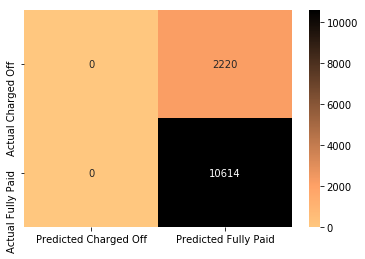

In [429]:
nice_confusion(y_val, y_pred);

In [430]:
print(classification_report(y_val, y_pred))

C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

 Charged Off       0.00      0.00      0.00      2220
  Fully Paid       0.83      1.00      0.91     10614

    accuracy                           0.83     12834
   macro avg       0.41      0.50      0.45     12834
weighted avg       0.68      0.83      0.75     12834



Predict 100% probability for majority class.

In [431]:
y_pred_proba = np.full_like(y_val, fill_value=1.0)
roc_auc_score(y_val, y_pred_proba)

0.5

In [432]:
y_pred_proba

array([1.0, 1.0, 1.0, ..., 1.0, 1.0, 1.0], dtype=object)

Any constant will result in a 0.5 roc_auc

### Get actual results of loans to compare with predictions.

In [433]:
columns = ['issue_d', 'grade', 'percent_paid', 'term', 'int_rate']
results_train = X_train[columns].copy()
results_val = X_val[columns].copy()
results_test = X_test[columns].copy()

## Clean Data

There are lots of missing values

In [434]:
nulls = X_train.isnull().sum().sort_values(ascending=False)
nulls = nulls.index[:73].tolist()

In [435]:
def clean_it_up(data, high_nulls, train=False, y_train=None):
    df = data.copy()
    
    df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], infer_datetime_format=True)
    df['earliest_cr_line'] = df['issue_d'] - df['earliest_cr_line']
    df['earliest_cr_line'] = df['earliest_cr_line'].dt.days

    df['sec_app_earliest_cr_line'] = pd.to_datetime(df['sec_app_earliest_cr_line'], infer_datetime_format=True, errors='coerce')
    df['sec_app_earliest_cr_line'] = df['issue_d'] - df['sec_app_earliest_cr_line']
    df['sec_app_earliest_cr_line'] = df['sec_app_earliest_cr_line'].dt.days

    df['issue_d_year'] = df['issue_d'].dt.year
    df['issue_d_month'] = df['issue_d'].dt.month

    # Percentage strings -> float.
    df['int_rate'] = df['int_rate'].str.strip('%').astype(float)
    df['revol_util'] = df['revol_util'].str.strip('%').astype(float)
    
    # Make some employee categories.
    df['emp_title'] = df['emp_title'].str.lower()
    df['emp_teacher'] = df['emp_title'].str.contains('teacher', na=False)
    df['emp_nurse'] = df['emp_title'].str.contains('nurse|rn', na=False)
    df['emp_mid_manage'] = df['emp_title'].str.contains('manager|supervisor', na=False)
    df['emp_up_manage'] = df['emp_title'].str.contains('owner|director|president|officer|^c.o$')
    df['emp_title'] = df['emp_title'].str.len()
    
    df['desc'] = df['desc'].str.len()
    df['title'] = df['title'].str.len()
    
    # Columns with many NANs converted to binary.
    for col in high_nulls:
        df[col + '_NULL'] = df[col].isnull()
    
    # Drop columns.
    df = df.drop(columns=['id',
                          'member_id',
                          'grade',
                          'zip_code',
                          'issue_d',
                          'percent_paid',
                          'url'])
                          
    features = ['acc_open_past_24mths', 'addr_state', 'all_util', 'annual_inc', 
                'annual_inc_joint', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 
                'collections_12_mths_ex_med', 'delinq_amnt', 'desc_NULL', 'dti', 
                'dti_joint', 'earliest_cr_line', 'emp_length', 'emp_length_NULL', 
                'emp_title', 'emp_title_NULL', 'emp_teacher', 'emp_nurse', 'emp_mid_manage',
                'emp_up_manage', 
                'funded_amnt', 'home_ownership', 'inq_last_12m', 'inq_last_6mths', 
                'installment', 'int_rate', 'issue_d_month', 'issue_d_year', 'loan_amnt', 
                'max_bal_bc', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 
                'mo_sin_rcnt_rev_tl_op', 'mort_acc', 'mths_since_last_major_derog_NULL', 
                'mths_since_last_record', 'mths_since_recent_bc', 'mths_since_recent_inq', 
                'num_actv_bc_tl', 'num_actv_rev_tl', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0', 
                'num_tl_120dpd_2m_NULL', 'open_rv_12m_NULL', 'open_rv_24m', 
                'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'purpose', 
                'revol_bal', 'revol_bal_joint', 'sec_app_earliest_cr_line', 
                'sec_app_open_acc', 'sec_app_open_act_il', 
                'sub_grade', 'term', 'title', 'title_NULL', 'tot_coll_amt', 
                'tot_hi_cred_lim', 'total_acc', 'total_bal_il', 'total_bc_limit', 
                'total_cu_tl', 'total_rev_hi_lim']
    
#     # Impute mean for features with fewer NANs
#     for col in df:
#         if df[col].isnull().sum() > 0:
#             df[col] = df[col].fillna(df[col].mean())
    
    # Transform sub_grade to float ranking 1.1 -7.5
    def sub_grade(x):
        first = ord(x[0]) - 64
        last = int(x[1]) / 10
        return first + last
    
    df['sub_grade'] = df['sub_grade'].apply(sub_grade)

    df = df[features]
    
    return df, y_train


In [436]:
X_train, y_train = clean_it_up(X_train, nulls, train=True, y_train=y_train)
X_val, _ = clean_it_up(X_val, nulls)
X_test, _ = clean_it_up(X_test, nulls)

In [437]:
X_train.shape, X_val.shape, X_test.shape

((71960, 67), (12834, 67), (12834, 67))

Train a model.

In [438]:
processor = make_pipeline(OrdinalEncoder(),
                          SimpleImputer(verbose=10))

X_train_ = processor.fit_transform(X_train)
X_val_ = processor.transform(X_val)
X_test_ = processor.transform(X_test)

print(X_train_.shape, X_val_.shape, X_test_.shape)

(71960, 67) (12834, 67) (12834, 67)


In [439]:
model = RandomForestClassifier(n_estimators=250,
                               n_jobs=-1, 
                               random_state=42)

model.fit(X_train_, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [440]:
# Accuracy score.
y_pred = model.predict(X_val_)
accuracy_score(y_val, y_pred)

0.8210222845566464

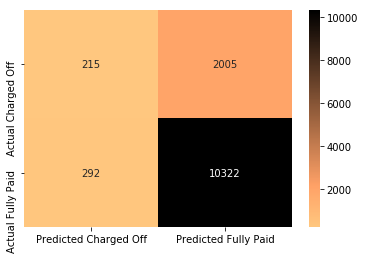

In [441]:
# Confusion matrix.
nice_confusion(y_val, y_pred);

In [442]:
# Precision and recall.
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

 Charged Off       0.42      0.10      0.16      2220
  Fully Paid       0.84      0.97      0.90     10614

    accuracy                           0.82     12834
   macro avg       0.63      0.53      0.53     12834
weighted avg       0.77      0.82      0.77     12834



In [443]:
y_pred_proba = model.predict_proba(X_val_)[:,1]
roc_auc_score(y_val, y_pred_proba)

0.6954156035628619

Visulalize ROC curve.

In [444]:
def set_threshold(y_true, y_pred_proba, threshold):
    
    # Apply threshold to probabilies of positive prediction.
    class_0, class_1 = unique_labels(y_true)
    y_pred = np.full_like(y_true, fill_value=class_0)
    y_pred[y_pred_proba > threshold] = class_1

    # Plot distribution of predicted probabilities.
    ax = sns.distplot(y_pred_proba)
    ax.axvline(threshold, color='r')
    plt.title('Distribution of predicted probabilities')
    plt.show()
    
    # Calculate true positive and false positive rates.
    true_pos = (y_pred == y_true) & (y_pred == class_1)
    false_pos = (y_pred != y_true) & (y_pred == class_1)
    actual_pos = y_true == class_1
    actual_neg = y_true == class_0
    true_pos_rate = true_pos.sum() / actual_pos.sum()
    false_pos_rate = false_pos.sum() / actual_neg.sum()
    print(f'True Positive Rate: {true_pos_rate}')
    print(f'False Positive Rate: {false_pos_rate}')
    
    # Plot ROC curve.
    fpr, tpr, thresholds = roc_curve(y_true==class_1, y_pred_proba)
    plt.plot(fpr, tpr)
    plt.title('ROC Curve')
    plt.ylabel('False Positive Rate')
    plt.xlabel('True Positive Rate')
    
    # Plot point for current threshold.
    plt.scatter(false_pos_rate, true_pos_rate)
    plt.show()
    
    print(f'Area under ROC: {roc_auc_score(y_true, y_pred_proba)}')
    
    nice_confusion(y_true, y_pred)
    print(classification_report(y_true, y_pred))


In [445]:
interact(set_threshold,
        y_true=fixed(y_val),
        y_pred_proba=fixed(y_pred_proba),
        threshold=(0, 1, 0.05));

interactive(children=(FloatSlider(value=0.0, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…

Find feature importance and trim features.

In [446]:
%%time
imputer = PermutationImportance(model,
                                scoring='roc_auc',
                                cv='prefit',
                                n_iter=5,
                                random_state=42
                                )

imputer.fit(X_val_, y_val)

Wall time: 4min 9s


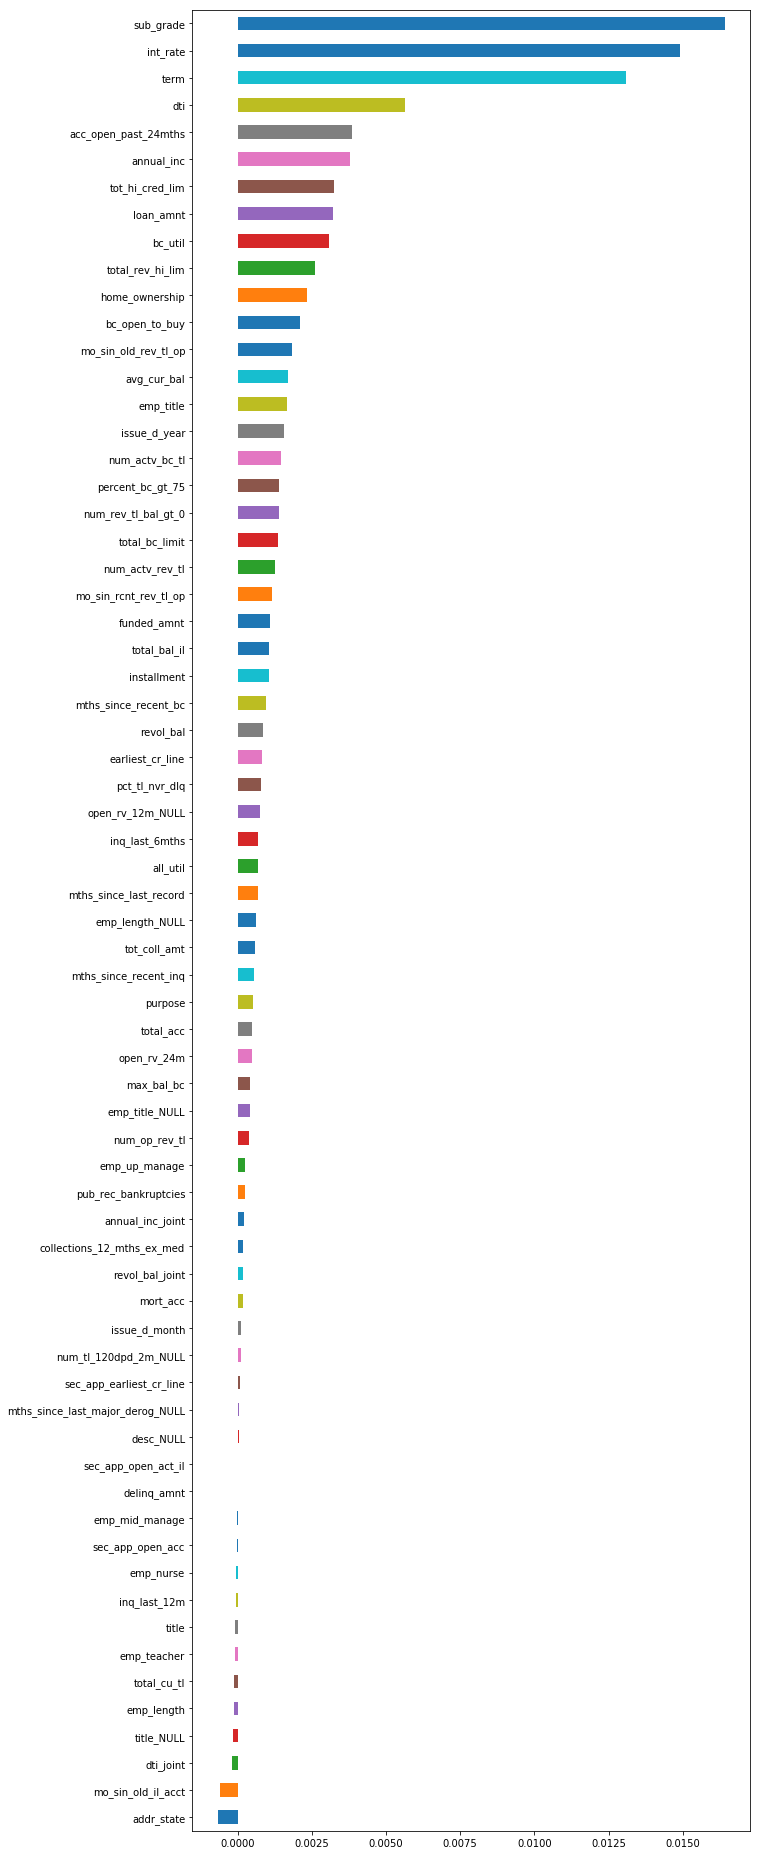

In [447]:
importance = pd.Series(imputer.feature_importances_, X_val.columns)
plt.figure(figsize=(10, len(X_val.columns.tolist()) / 2))
importance.sort_values(ascending=True).plot.barh();

In [448]:
mask = imputer.feature_importances_ > 0

features = X_train.columns[mask]
X_train_trimmed = X_train[features]
X_val_trimmed = X_val[features]
X_test_trimmed = X_test[features]

processor = make_pipeline(OrdinalEncoder(),
                          SimpleImputer())

X_train_t = processor.fit_transform(X_train_trimmed)
X_val_t = processor.transform(X_val_trimmed)
X_test_t = processor.transform(X_test_trimmed)

In [449]:
model = RandomForestClassifier(n_estimators=250,
                               n_jobs=-1,
                               random_state=42)
model.fit(X_train_t, y_train)
y_pred_proba = model.predict_proba(X_val_t)[:, 1]

In [450]:
interact(set_threshold,
        y_true=fixed(y_val),
        y_pred_proba=fixed(y_pred_proba),
        threshold=(0, 1, 0.025));

interactive(children=(FloatSlider(value=0.0, description='threshold', max=1.0, step=0.025), Output()), _dom_cl…

Expected value calculations.

In [451]:
def results(result_df, y_true, y_pred_proba):
    df = result_df.copy()
    df['loan_status'] = y_true
    df['pred_proba'] = y_pred_proba
    df['int_rate'] = df['int_rate'].str.strip('%').astype(float)
    df['term'] = df['term'].str.replace(r'\D', '').astype(int) / 12
    df['best_case'] = 25 * (1 + df['int_rate'] / 100)**df['term']
    df['worst_case'] = -25
    df['expected_value'] = (df['pred_proba'] * df['best_case'] +
                            (1 - df['pred_proba']) * df['worst_case']).astype(float)
    df['actual_return'] = (df['percent_paid'] * 25) - 25
    return df

In [452]:
val_result = results(results_val, y_val, y_pred_proba)

In [453]:
val_result.head()

,issue_d,grade,percent_paid,term,int_rate,loan_status,pred_proba,best_case,worst_case,expected_value,actual_return
38120,2018-09-01,D,1.022559,5.0,20.89,Fully Paid,0.508,64.549353,-25,20.491072,0.563966
39527,2015-09-01,B,1.072228,3.0,8.18,Fully Paid,0.936,31.650527,-25,28.024893,1.805690
88689,2014-03-01,B,1.175463,3.0,10.99,Fully Paid,0.900,34.181535,-25,28.263382,4.386568
3911,2016-11-01,C,1.127852,3.0,13.99,Fully Paid,0.648,37.028854,-25,15.194697,3.196304
37026,2016-07-01,B,1.040775,3.0,10.49,Charged Off,0.712,33.721659,-25,16.809821,1.019375


In [454]:
model = XGBClassifier(n_jobs=-1,
                      random_state=42)
eval_set = [(X_train_t, y_train),
            (X_val_t, y_val)]

model.fit(X_train_t,
          y_train,
          eval_set=eval_set,
          eval_metric='auc',
          early_stopping_rounds=50,
          verbose=0)

y_pred_proba = model.predict_proba(X_val_t)[:, 1]

In [455]:
val_result = results(results_val, y_val, y_pred_proba)

In [456]:
val_result.head(10)

,issue_d,grade,percent_paid,term,int_rate,loan_status,pred_proba,best_case,worst_case,expected_value,actual_return
38120,2018-09-01,D,1.022559,5.0,20.89,Fully Paid,0.588122,64.549353,-25,27.665946,0.563966
39527,2015-09-01,B,1.072228,3.0,8.18,Fully Paid,0.882220,31.650527,-25,24.978246,1.805690
88689,2014-03-01,B,1.175463,3.0,10.99,Fully Paid,0.888709,34.181535,-25,27.595170,4.386568
3911,2016-11-01,C,1.127852,3.0,13.99,Fully Paid,0.599177,37.028854,-25,12.166285,3.196304
37026,2016-07-01,B,1.040775,3.0,10.49,Charged Off,0.715900,33.721659,-25,17.038832,1.019375
118661,2015-10-01,A,1.036262,3.0,6.89,Fully Paid,0.926802,30.531718,-25,26.466896,0.906550
1292,2018-08-01,B,1.059693,3.0,10.47,Fully Paid,0.837696,33.703350,-25,24.175566,1.492325
89907,2014-06-01,C,1.219058,3.0,13.35,Fully Paid,0.799716,36.408651,-25,24.109469,5.476453
41378,2015-02-01,C,1.096105,3.0,14.65,Fully Paid,0.732311,37.675774,-25,20.898189,2.402625
100800,2014-04-01,A,1.065706,3.0,6.62,Fully Paid,0.928803,30.300936,-25,26.363677,1.642656


Simulate picking loans by grade and with model.

In [457]:
def simulate(df, n_picks=40, n_sims=10000,
             grades=['A', 'B', 'C', 'D'],
             start='2007-07-01',
             end='2019-03-01',
             min_proba=.5,
             min_value=-25):
    
    condition = (df['grade'].isin(grades) &
                 (df['issue_d'] >= start) &
                 (df['issue_d'] <= end) &
                 (df['expected_value'] >= min_value) &
                 (df['pred_proba'] >= min_proba))
    
    candidates = df[condition]
    
    sims = []
    for _ in tnrange(n_sims):
        picks = candidates.sample(n_picks).copy()
        picks['paid'] = picks['percent_paid'] * 25
        earned = picks['paid'].sum()
        sims.append(earned)
        
    simulations = pd.Series(sims)
    sns.distplot(simulations)
    plt.axvline(x=1000)
    percent = percentileofscore(simulations, 1000)
    display(Markdown(f'#### {n_picks} loans picked from {len(candidates)} possible loans.'))
    display(Markdown(f'- Dates: {start} - {end}\n- Grades: {grades}\n- Expedted value >= {min_value}'))
    display(Markdown(f'- Minimum predicted probability of loan repayment: {min_proba}'))
    display(Markdown(f'#### Range of results from {n_sims} simulations:'))
    print(simulations.describe().to_string())
    print()
    plt.title(f'{percent}% of simulations did not profit')


#### 40 loans picked from 12360 possible loans.

- Dates: 2007-07-01 - 2019-03-01
- Grades: ['A', 'B', 'C', 'D']
- Expedted value >= -25

- Minimum predicted probability of loan repayment: 0.5

#### Range of results from 10000 simulations:

count    10000.000000
mean      1049.633706
std         40.865327
min        881.255530
25%       1023.049483
50%       1051.596801
75%       1078.420137
max       1171.893023



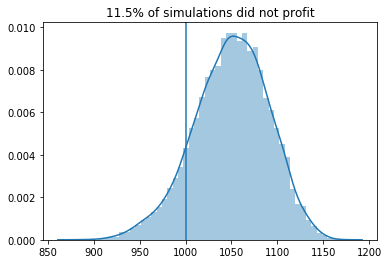

In [458]:
simulate(val_result)

#### 40 loans picked from 2520 possible loans.

- Dates: 2007-07-01 - 2019-03-01
- Grades: ['A']
- Expedted value >= -25

- Minimum predicted probability of loan repayment: 0.5

#### Range of results from 10000 simulations:

count    10000.000000
mean      1053.777387
std         22.965951
min        927.541221
25%       1039.861886
50%       1056.975818
75%       1070.725099
max       1101.782451



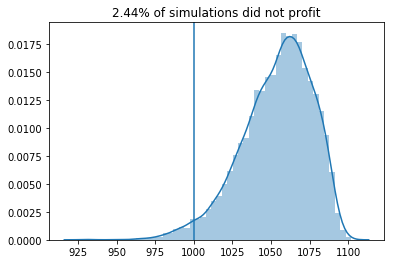

In [459]:
simulate(val_result, grades=['A'])

#### 40 loans picked from 2567 possible loans.

- Dates: 2007-07-01 - 2019-03-01
- Grades: ['A', 'B', 'C', 'D']
- Expedted value >= 26.206900662334824

- Minimum predicted probability of loan repayment: 0.5

#### Range of results from 10000 simulations:

count    10000.000000
mean      1096.949311
std         31.792334
min        936.477687
25%       1076.827562
50%       1098.863260
75%       1119.401620
max       1197.903230



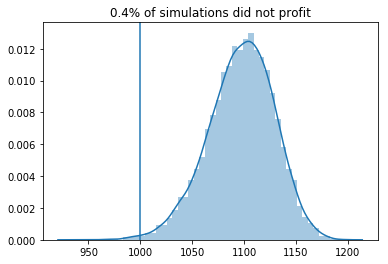

In [460]:
min_val = np.percentile(val_result['expected_value'], 80)
simulate(val_result, min_value=min_val)

#### 40 loans picked from 1950 possible loans.

- Dates: 2007-07-01 - 2019-03-01
- Grades: ['A', 'B', 'C', 'D']
- Expedted value >= 26.206900662334824

- Minimum predicted probability of loan repayment: 0.8

#### Range of results from 10000 simulations:

count    10000.000000
mean      1086.580368
std         23.039355
min        963.240556
25%       1072.262081
50%       1088.981807
75%       1103.350543
max       1151.664444



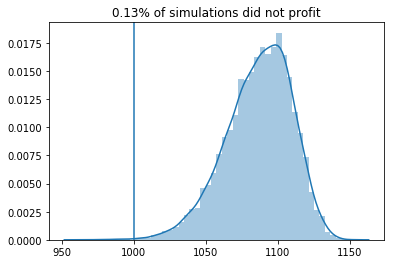

In [461]:
simulate(val_result, min_value=min_val, min_proba=.8)

#### 40 loans picked from 45 possible loans.

- Dates: 2007-07-01 - 2019-03-01
- Grades: ['D']
- Expedted value >= 26.206900662334824

- Minimum predicted probability of loan repayment: 0.8

#### Range of results from 10000 simulations:

count    10000.000000
mean      1134.340806
std         10.612588
min       1112.340827
25%       1126.691948
50%       1132.312493
75%       1140.517424
max       1184.470036



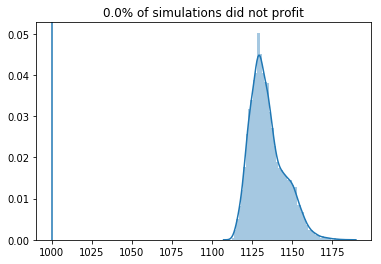

In [462]:
simulate(val_result, min_value=min_val, min_proba=.8, grades=['D'])

Test time!

In [463]:
y_pred_proba = model.predict_proba(X_test_t)[:, 1]
print(f'Test ROC AUC: {roc_auc_score(y_test, y_pred_proba)}')

Test ROC AUC: 0.7084422423697649


#### 40 loans picked from 1941 possible loans.

- Dates: 2007-07-01 - 2019-03-01
- Grades: ['A', 'B', 'C', 'D']
- Expedted value >= 26.23471653006807

- Minimum predicted probability of loan repayment: 0.8

#### Range of results from 10000 simulations:

count    10000.000000
mean      1086.388704
std         25.479695
min        972.253958
25%       1070.415281
50%       1088.791350
75%       1104.481494
max       1155.642627



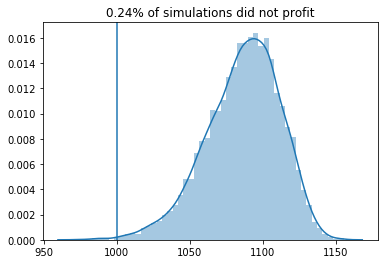

In [464]:
test_result = results(results_test, y_test, y_pred_proba)
min_val = np.percentile(test_result['expected_value'], 80)
simulate(test_result, min_value=min_val, min_proba=.8)

Shapley things.

In [465]:
test_result.head()

,issue_d,grade,percent_paid,term,int_rate,loan_status,pred_proba,best_case,worst_case,expected_value,actual_return
8953,2015-02-01,A,1.082500,3.0,7.89,Fully Paid,0.891353,31.396670,-25,25.269315,2.062508
56181,2012-11-01,C,1.176062,3.0,15.31,Fully Paid,0.849424,38.330186,-25,28.794150,4.401542
49863,2016-06-01,C,0.286589,5.0,15.31,Charged Off,0.368306,50.965333,-25,2.978455,-17.835267
51668,2017-04-01,A,1.091499,3.0,7.99,Fully Paid,0.888390,31.484053,-25,25.179861,2.287463
38340,2017-05-01,B,1.103063,3.0,10.42,Fully Paid,0.846287,33.657607,-25,24.641154,2.576565


In [472]:
grades=['A', 'B', 'C', 'D']
start='2007-07-01'
end='2019-03-01'
min_proba=.5
min_value=-25

df = test_result.copy()

condition = (df['grade'].isin(grades) &
            (df['issue_d'] >= start) &
            (df['issue_d'] <= end) &
            (df['expected_value'] >= min_value) &
            (df['pred_proba'] >= min_proba))

possible = df[condition]
picks = possible.sample(40, random_state=42).copy()
pick = picks.index[2]
print(pick)
picks[picks.index == pick]
# picks

122307


,issue_d,grade,percent_paid,term,int_rate,loan_status,pred_proba,best_case,worst_case,expected_value,actual_return
122307,2018-09-01,A,1.033478,3.0,6.11,Fully Paid,0.923863,29.868193,-25,25.690674,0.836942


In [473]:
data = X_test_trimmed[X_test_trimmed.index == pick]
data

,acc_open_past_24mths,all_util,annual_inc,annual_inc_joint,avg_cur_bal,bc_open_to_buy,bc_util,collections_12_mths_ex_med,delinq_amnt,desc_NULL,dti,earliest_cr_line,emp_length_NULL,emp_title,emp_title_NULL,emp_up_manage,funded_amnt,home_ownership,inq_last_6mths,installment,int_rate,issue_d_month,issue_d_year,loan_amnt,max_bal_bc,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,mths_since_last_major_derog_NULL,mths_since_last_record,mths_since_recent_bc,mths_since_recent_inq,num_actv_bc_tl,num_actv_rev_tl,num_op_rev_tl,num_rev_tl_bal_gt_0,num_tl_120dpd_2m_NULL,open_rv_12m_NULL,open_rv_24m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,purpose,revol_bal,revol_bal_joint,sec_app_earliest_cr_line,sec_app_open_act_il,sub_grade,term,tot_coll_amt,tot_hi_cred_lim,total_acc,total_bal_il,total_bc_limit,total_rev_hi_lim
122307,4.0,25.0,60000.0,NaN,17731.0,43079.0,5.3,0.0,0.0,True,19.62,5266,False,13.0,False,False,20000.0,MORTGAGE,0.0,609.44,6.11,9,2018,20000.0,1725.0,173.0,9.0,1.0,True,NaN,9.0,0.0,2.0,4.0,5.0,4.0,False,False,3.0,100.0,0.0,0.0,debt_consolidation,3749.0,NaN,NaN,NaN,1.1,36 months,0.0,199060.0,7.0,16091.0,45500.0,53400.0


In [474]:
data_ = processor.transform(data)
data_ = pd.DataFrame(data_)
data_.columns = data.columns

In [475]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_)
shap.force_plot(explainer.expected_value, shap_values, data_)

Use the class_weight parameter in sklearn.

In [65]:
def class_weighter(n_samples=1000, weights=(0.95, 0.5), class_sep=.8, class_weight=None):
    X, y = make_classification(n_samples=n_samples,
                               n_features=2,
                               n_informative=2,
                               n_redundant=0,
                               n_repeated=0,
                               n_classes=2, 
                               n_clusters_per_class=2,
                               weights=weights,
                               class_sep=class_sep,
                               random_state=42)
    X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X,
                                                                          y,
                                                                          train_size=.8,
                                                                          val_size=.1,
                                                                          test_size=.1,
                                                                          random_state=42)
    
    
    model = LogisticRegression(solver='lbfgs',
                               class_weight=class_weight)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    print(classification_report(y_val, y_pred))
    nice_confusion(y_val, y_pred)
    
    plt.figure(figsize=(10, 6))
    plot_decision_regions(X_val, y_val, model, legend=0);

In [66]:
# class_weighter()

In [67]:
# class_weighter(class_weight='balanced')

In [68]:
# class_weighter(class_sep=.5, class_weight={0:1, 1:10})

In [69]:
# pipeline1 = make_pipeline(OrdinalEncoder(),
#                           XGBClassifier(early_stopping_rounds=50,
#                                        n_jobs=-1))
# pipeline1.fit(X_train, y_train)